In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
#np.set_printoptions(precision=3)
np.set_printoptions(precision=3, suppress=True)
torch.manual_seed(101)

### Initialial visulation

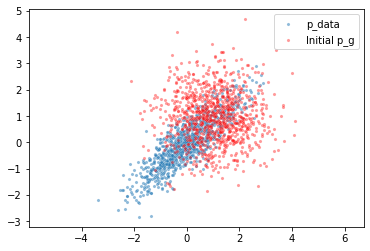

In [2]:
mu_p = torch.tensor([0.0, 0.0])
scale_p = torch.tensor([[1.0000, 0.0000],
                        [0.8, 0.5]])
cov_p = scale_p@scale_p.T

p_data = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu_p, covariance_matrix=cov_p)

mu_q = torch.tensor([1.0, 1.0])
scale_q = torch.tensor([[1.0, 0], [0, 1.0]])

cov_q = scale_q@scale_q.T
q_g = torch.distributions.multivariate_normal.MultivariateNormal(loc=mu_q, covariance_matrix=cov_q)

x_p = p_data.sample([1000])
x_q = q_g.sample([1000])
sns.scatterplot(x=x_p[:, 0], y=x_p[:, 1], s=10, label='p_data', alpha=0.5)
sns.scatterplot(x=x_q[:, 0], y=x_q[:, 1], s=10, label='Initial p_g', color='r', alpha=0.4)
plt.axis('equal')
plt.legend()
plt.show()


In [3]:
# Define the log prob of gaussian 
def log_prob(mu, scale, x):
    cov = scale@scale.T
    dim = x.shape[1]
    a = -0.5 * (dim * np.log(2 * np.pi) + torch.log(1e-8+torch.det(cov)))
    b =  -0.5*torch.sum((x - mu) @ torch.inverse(cov) * (x - mu), axis=1)
    return a + b

# define f divergence as f(r)
def f(r, methood='Rkl'):
    if methood=='Rkl':
        return -torch.log(r)
    elif methood=='Fkl':
        return r*torch.log(r)
    elif methood=='Chi':
        return (r-1)**2
    elif methood=='Hellinger':
        return (torch.sqrt(r)-1)**2
    elif methood=='Js':
        return -(r+1)*torch.log((1+r)/2) + r*torch.log(r)

# define cost function h(logr)
def h(logr, methood='exp'):
    if methood=='exp':
        return torch.exp(1.5*logr)
    

def train(detach=False, func='f', method='Rkl', number_iter=1000, lr=0.01):
    
    mu_q = torch.tensor([1.0, 1.0])
    scale_q = torch.tensor([[1.0, 0], [0, 1.0]])

    mu_q.requires_grad = True
    scale_q.requires_grad = True
    opt = torch.optim.Adam([mu_q, scale_q], lr=lr)
    
    for i in range(number_iter):
        opt.zero_grad()
        
        z = torch.randn([1000, 2])
        
        # reparameterization trick
        x = mu_q + z @ scale_q.T
        if not detach:
            log_ratio = log_prob(mu_p, scale_p, x) - log_prob(mu_q, scale_q, x)
        else:
            log_ratio = log_prob(mu_p, scale_p, x) - log_prob(mu_q.detach(), scale_q.detach(), x)
            
        r = torch.exp(log_ratio)
        if func == 'f':
            loss = torch.mean(f(r, method))
        if func == 'h':
            loss = -torch.mean(h(log_ratio, method))  
        loss.backward()
        opt.step()
        
    print('Minimizing divergence:', method)
    print('mu_pg:')
    print(mu_q.detach().numpy())
    print('\ncov_pg:')
    print((scale_q @ scale_q.T).detach().numpy())
   

    sns.scatterplot(x=x_p[:, 0], y=x_p[:, 1], s=10, label='p_data', alpha=0.7)
    sns.scatterplot(x=x.detach()[:, 0], y=x.detach()[:, 1], s=10, label='p_g', color='r', alpha=0.4)
    plt.axis('equal')
    
    plt.legend(prop={'size': 15})
    plt.show()
    print("*******************************************************************")

In [4]:
print('Target distribution has parameters:')
print('mu:\n')
print(mu_p.numpy())
print('\ncov:\n')
print((scale_p @ scale_p.T).numpy())

Target distribution has parameters:
mu:

[0. 0.]

cov:

[[1.   0.8 ]
 [0.8  0.89]]


## Standard Variational Inference  


Minimizing divergence: Rkl
mu_pg:
[0.006 0.005]

cov_pg:
[[0.985 0.79 ]
 [0.79  0.888]]


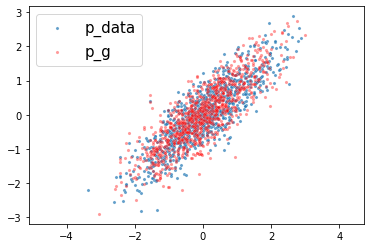

*******************************************************************
Minimizing divergence: Fkl
mu_pg:
[-0.005  0.003]

cov_pg:
[[1.001 0.801]
 [0.801 0.891]]


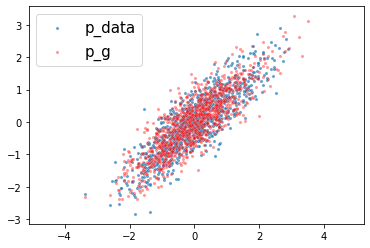

*******************************************************************
Minimizing divergence: Chi
mu_pg:
[0.001 0.001]

cov_pg:
[[1.004 0.803]
 [0.803 0.893]]


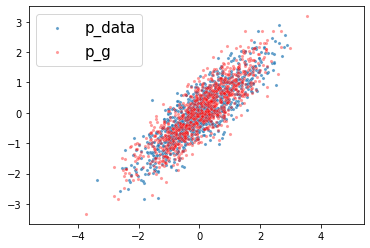

*******************************************************************
Minimizing divergence: Hellinger
mu_pg:
[0. 0.]

cov_pg:
[[1.   0.8 ]
 [0.8  0.89]]


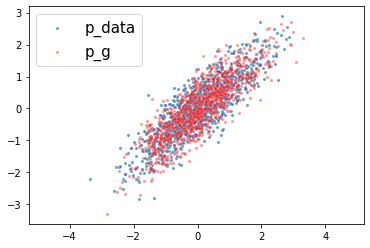

*******************************************************************
Minimizing divergence: Js
mu_pg:
[0. 0.]

cov_pg:
[[1.   0.8 ]
 [0.8  0.89]]


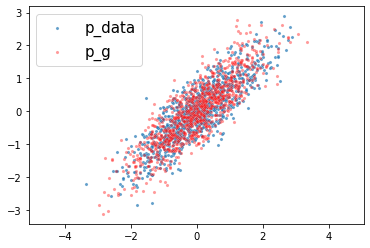

*******************************************************************
Minimizing divergence: exp
mu_pg:
[1.708 0.793]

cov_pg:
[[ 0.503 -0.544]
 [-0.544  1.928]]


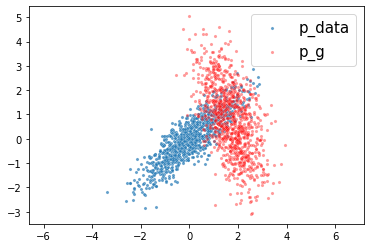

*******************************************************************


In [5]:
train(detach=False, method='Rkl', number_iter=1000, lr=0.01)
train(detach=False, method='Fkl', number_iter=3000, lr=0.01)
train(detach=False, method='Chi', number_iter=5000, lr=0.01)
train(detach=False, method='Hellinger', number_iter=3000, lr=0.01)
train(detach=False, method='Js', number_iter=3000, lr=0.01)
train(detach=False, func='h', method='exp', number_iter=2000, lr=0.01)

## Variational Inference with Detached Models

Minimizing divergence: Rkl
mu_pg:
[-0. -0.]

cov_pg:
[[1.   0.8 ]
 [0.8  0.89]]


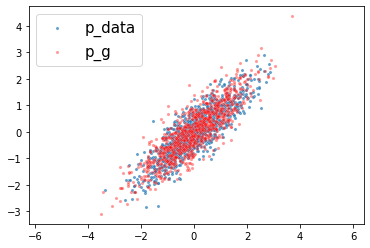

*******************************************************************
Minimizing divergence: Fkl
mu_pg:
[1.418 1.433]

cov_pg:
[[ 0.547 -0.477]
 [-0.477  0.53 ]]


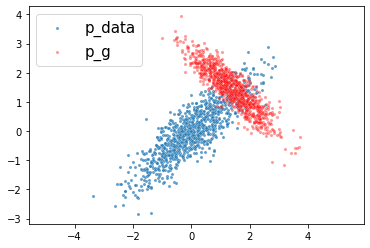

*******************************************************************
Minimizing divergence: Chi
mu_pg:
[1.391 1.282]

cov_pg:
[[ 0.532 -0.439]
 [-0.439  0.611]]


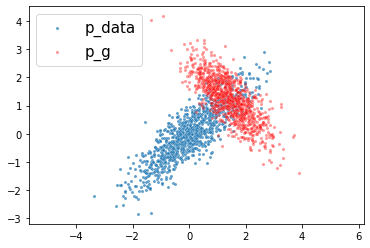

*******************************************************************
Minimizing divergence: Hellinger
mu_pg:
[1.512 1.523]

cov_pg:
[[ 0.441 -0.437]
 [-0.437  0.433]]


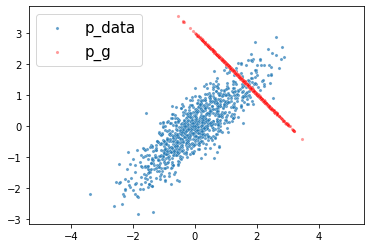

*******************************************************************
Minimizing divergence: Js
mu_pg:
[1.558 1.487]

cov_pg:
[[ 0.484 -0.47 ]
 [-0.47   0.487]]


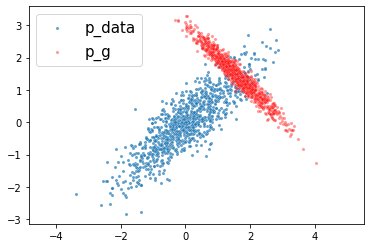

*******************************************************************
Minimizing divergence: exp
mu_pg:
[0. 0.]

cov_pg:
[[1.   0.8 ]
 [0.8  0.89]]


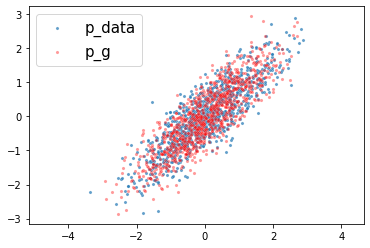

*******************************************************************


In [6]:
train(detach=True, method='Rkl', number_iter=1000, lr=0.01)
train(detach=True, method='Fkl', number_iter=3000, lr=0.001)
train(detach=True, method='Chi', number_iter=3000, lr=0.001)
train(detach=True, method='Hellinger', number_iter=3000, lr=0.001)
train(detach=True, method='Js', number_iter=3000, lr=0.001)
train(detach=True, func='h', method='exp', number_iter=3000, lr=0.01)